In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
metric = "rmse"
error = {
    name: xr.open_dataset(
        f"/pscratch/sd/t/timothys/nested-eagle/v0/baselines/{key}-forecasts-vs-hrrr-analysis/{metric}.lam.nc",
        decode_timedelta=True,
    )
    for name, key in zip(["HRRR", "GFS"], ["hrrr", "gfs"])
}
error["Nested-EAGLE Prototype"] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/v0/10percent/csmswt/ll10-win4320/inference-validation/{metric}.nested-lam.nc", decode_timedelta=True)

spatial = {
    name: xr.open_dataset(
        f"/pscratch/sd/t/timothys/nested-eagle/v0/baselines/{key}-forecasts-vs-hrrr-analysis/spatial.{metric}.lam.nc",
        decode_timedelta=True,
    )
    for name, key in zip(["HRRR", "GFS"], ["hrrr", "gfs"])
}
spatial["Nested-EAGLE Prototype"] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/v0/10percent/csmswt/ll10-win4320/inference-validation/spatial.{metric}.nested-lam.nc", decode_timedelta=True)

In [4]:
error = {k: error[k] for k in ["Nested-EAGLE Prototype", "HRRR", "GFS"]}
spatial = {k: spatial[k] for k in ["Nested-EAGLE Prototype", "HRRR", "GFS"]}

In [5]:
nice_names = {
    "sp": "Surface Pressure",
    "u10": "10m Zonal Wind",
    "v10": "10m Meridional Wind",
    "t2m": "2m Temperature",
    "sh2": "2m Specific Humidity",
    "gh": "Geopotential Height",
    "u": "Zonal Wind",
    "v": "Meridional Wind",
    "w": "Vertical Velocity",
    "t": "Temperature",
    "q": "Specific Humidity",
}

In [6]:
def single_plot(ax, dsdict, varname, sel=None, **kwargs):
    for label, xds in error.items():
        plotme = xds[varname] if sel is None else xds[varname].sel(**sel)
        df = plotme.to_dataframe().reset_index()
        sns.lineplot(
            data=df,
            x="fhr",
            y=varname,
            ax=ax,
            label=label,
            **kwargs,
        )
    xticks = plotme.fhr.values
    xticks = xticks if len(xticks)<10 else np.concatenate([ [xticks[0]], xticks[4::4]])
    ax.set(
        ylabel=metric.upper() if ax.get_subplotspec().is_first_col() else "",
        xlabel="Forecast Hour" if ax.get_subplotspec().is_last_row() else "",
        title=nice_names[varname] if ax.get_subplotspec().is_first_row() else "",
        xticks=xticks,
    )
    ax.legend(frameon=False)

In [7]:
def plot_surface_error(surface_vars, **kwargs):
    ncols = len(surface_vars)
    fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 4), constrained_layout=True)
    
    for varname, ax in zip(surface_vars, axs):
        single_plot(ax=ax, dsdict=error, varname=varname, **kwargs)
    return fig, axs

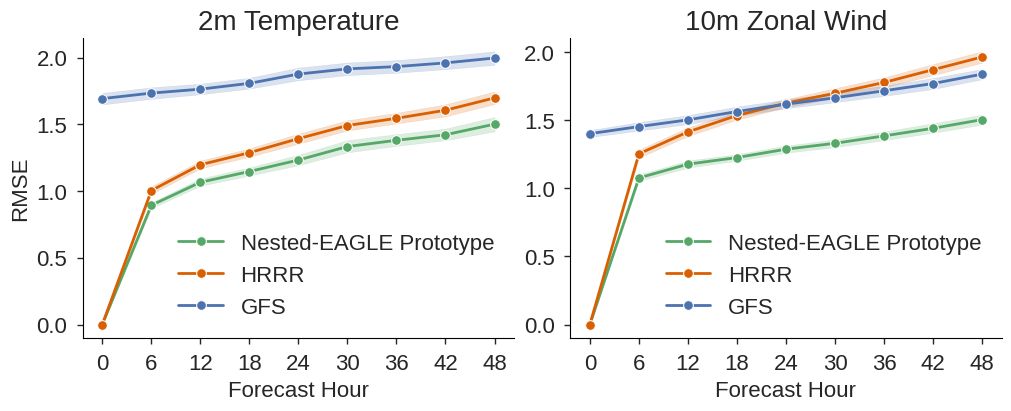

In [8]:
fig, axs = plot_surface_error(["t2m", "u10"], sel={"fhr": slice(49)}, marker="o")
fig.savefig(f"figures/surface_48h_rmse_2fields.jpeg", dpi=300, bbox_inches="tight")

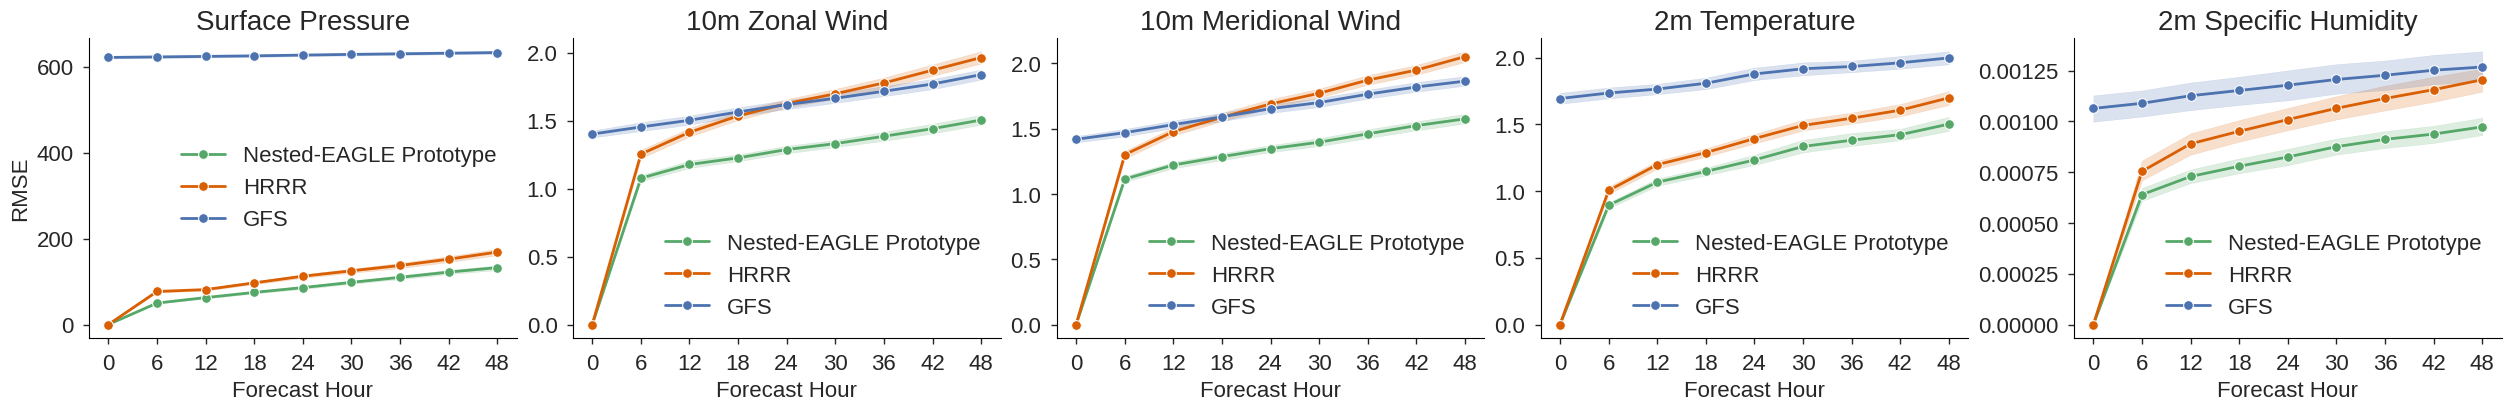

In [9]:
fig, axs = plot_surface_error(["sp", "u10", "v10", "t2m", "sh2"], sel={"fhr": slice(49)}, marker="o")
fig.savefig(f"figures/surface_48h_rmse_5fields.jpeg", dpi=300, bbox_inches="tight")

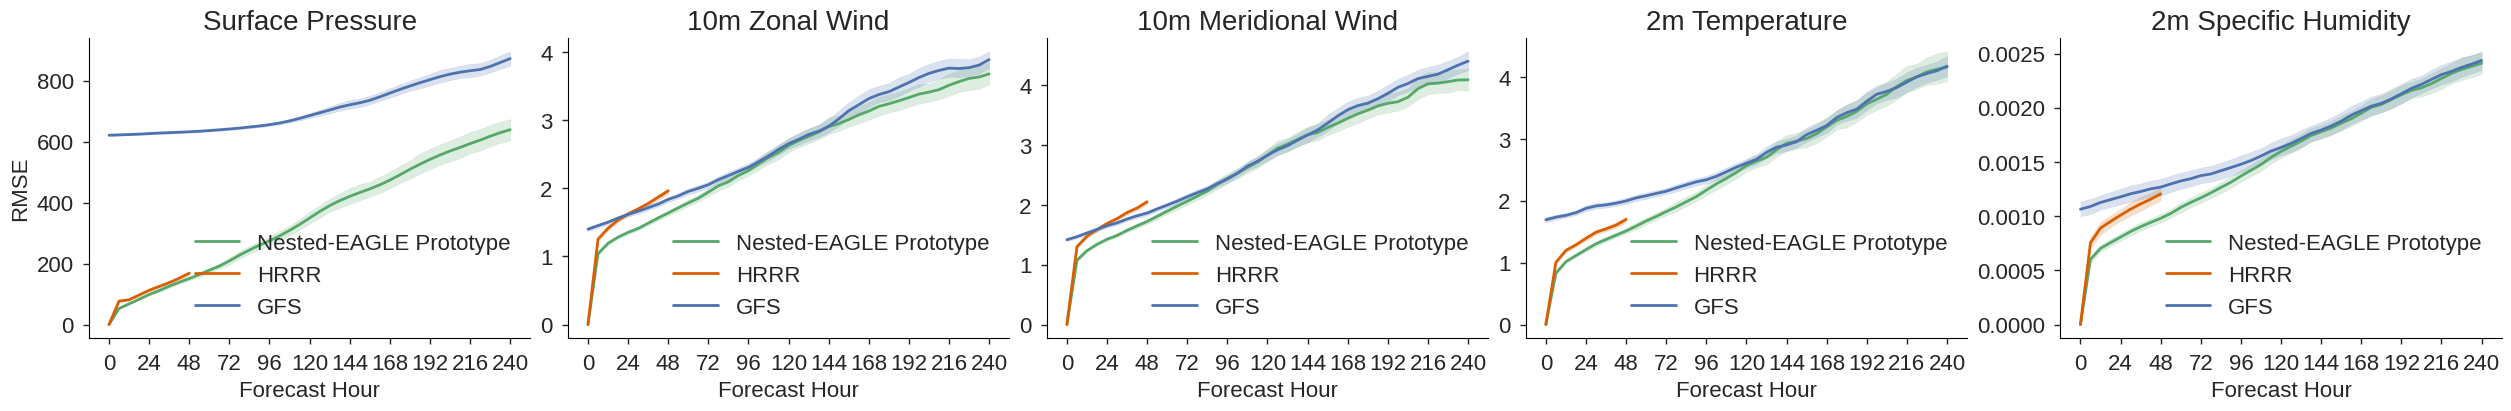

In [10]:
fig, axs = plot_surface_error(["sp", "u10", "v10", "t2m", "sh2"])
fig.savefig(f"figures/surface_10d_rmse_5fields.jpeg", dpi=300, bbox_inches="tight")

In [15]:
def plot_level_vars(level_vars, **kwargs):
    
    levels = error["HRRR"].sel(level=[500]).level.values
    ncols = len(level_vars)
    nrows = len(levels)
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.5*nrows), constrained_layout=True)

    if ncols == 1:
        axs = [axs]
    if nrows == 1:
        axs = [axs]
    

    sel = kwargs.pop("sel", {})
    for level, axr in zip(levels, axs):
        for varname, ax in zip(level_vars, axr):
            
            sel["level"] = level
            single_plot(ax=ax, dsdict=error, varname=varname, sel=sel, **kwargs)
            ax.legend(title=f"{level} hPa", frameon=False)
    return fig, axs

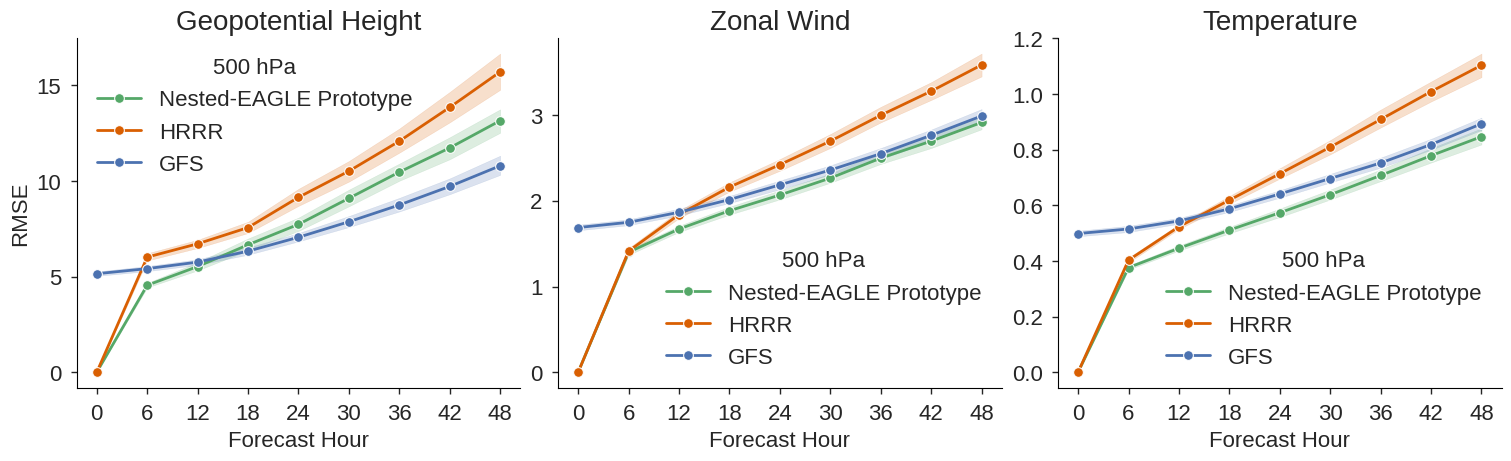

In [16]:
fig, axs = plot_level_vars(["gh", "u", "t"], sel={"fhr": slice(49)}, marker="o")
fig.savefig(f"figures/plevel_48h_rmse_3fields.jpeg", dpi=300, bbox_inches="tight")

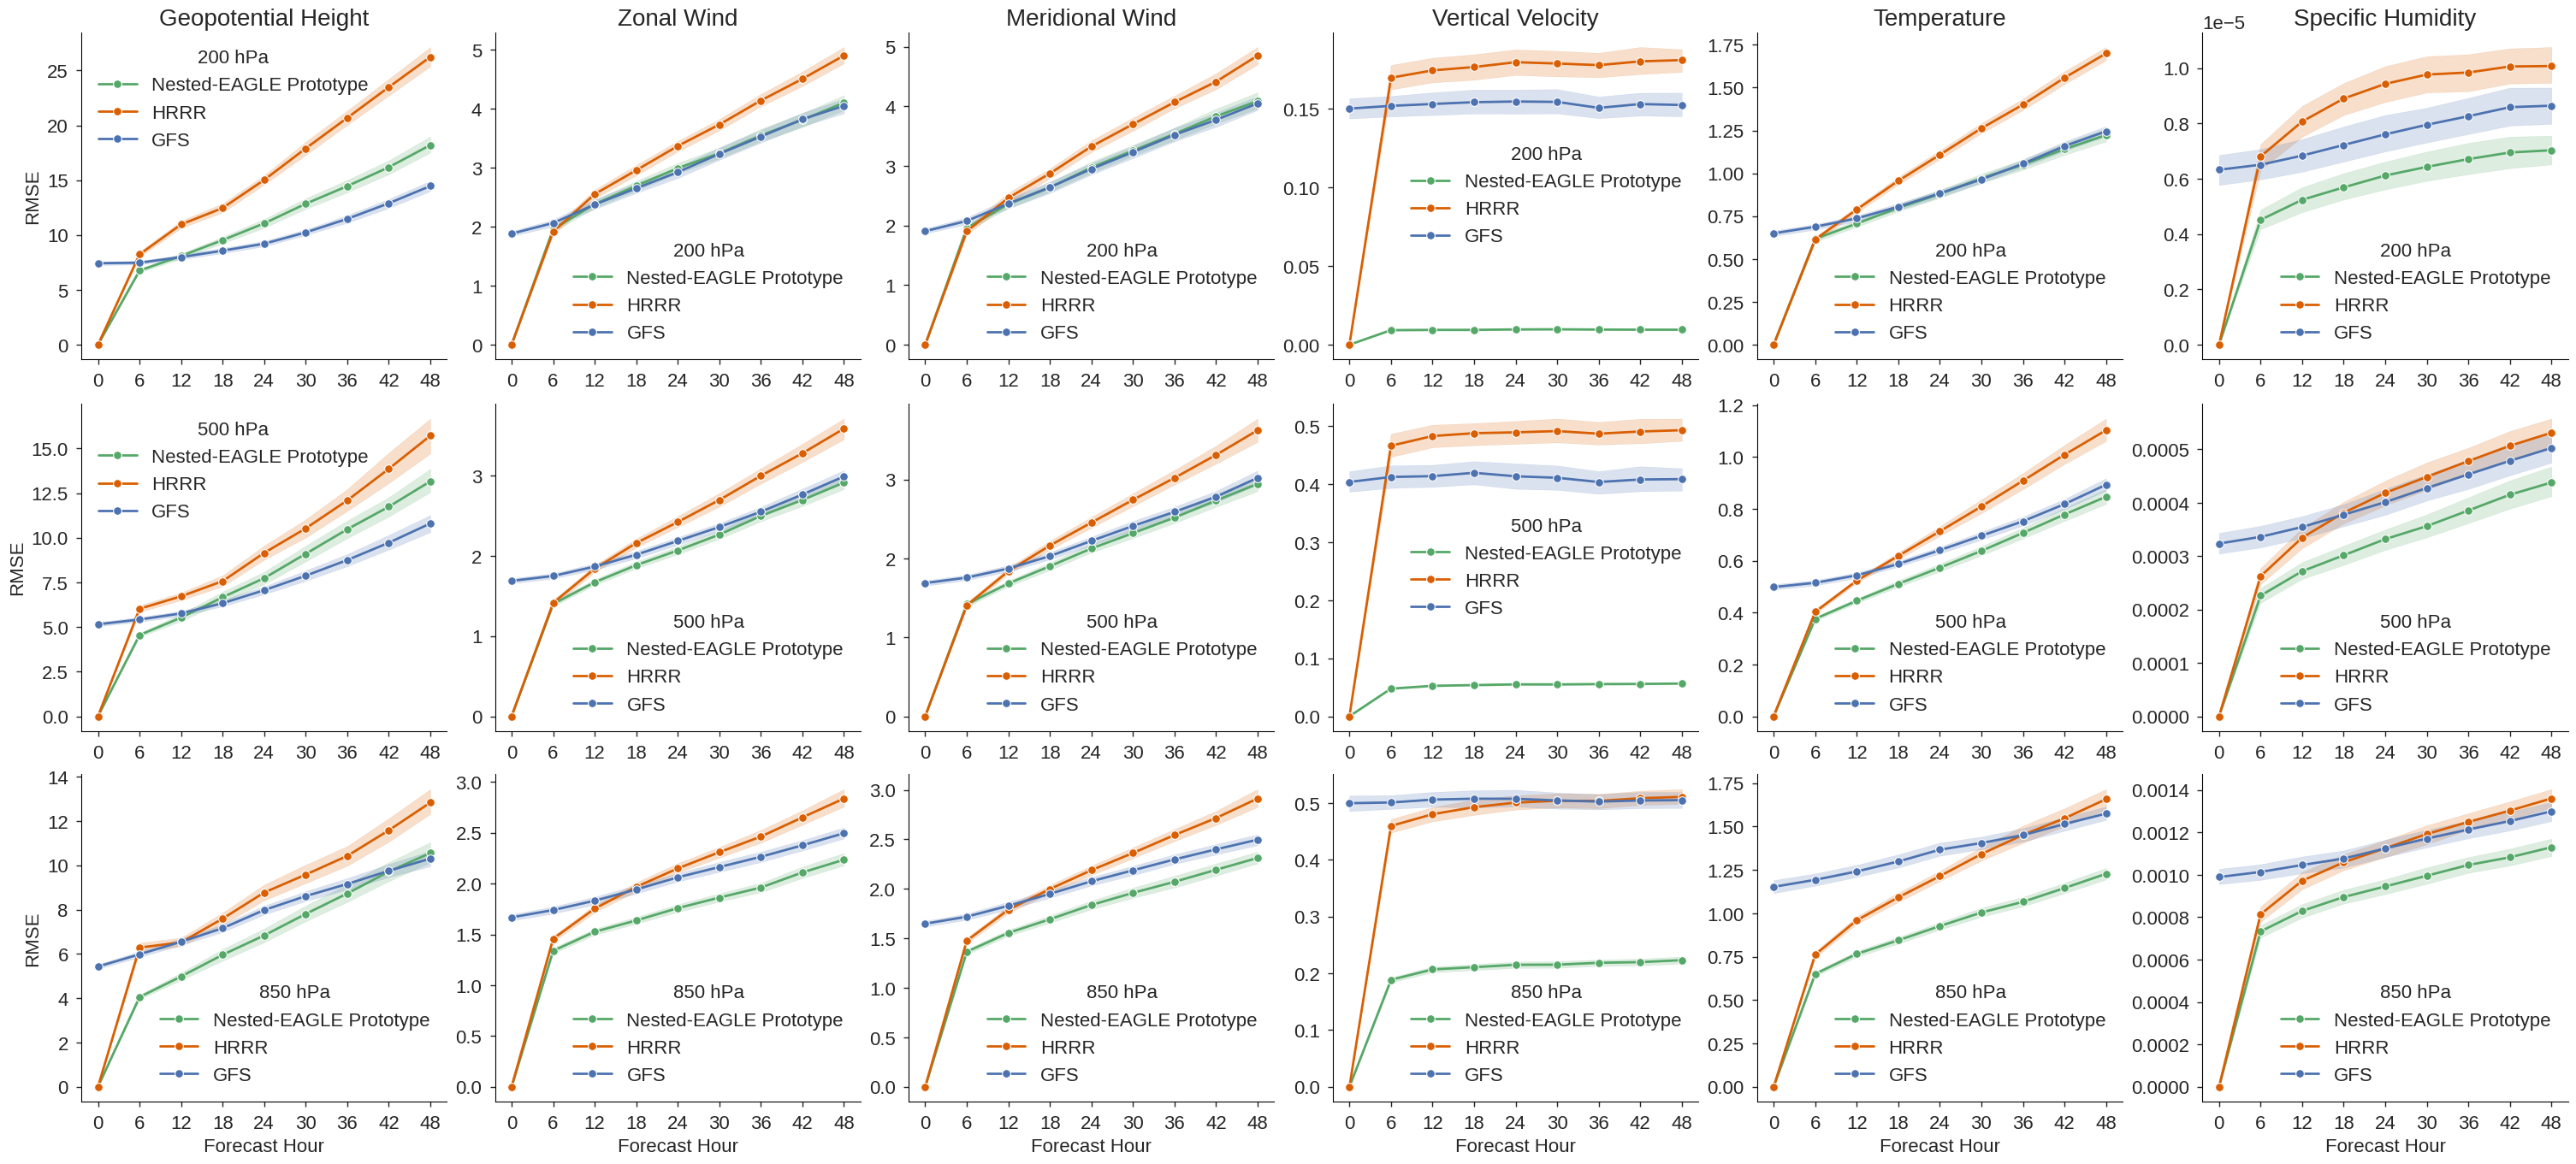

In [12]:
fig, axs = plot_level_vars(["gh", "u", "v", "w", "t", "q"], sel={"fhr": slice(49)}, marker="o")
fig.savefig(f"figures/plevel_48h_rmse_6fields.jpeg", dpi=300, bbox_inches="tight")

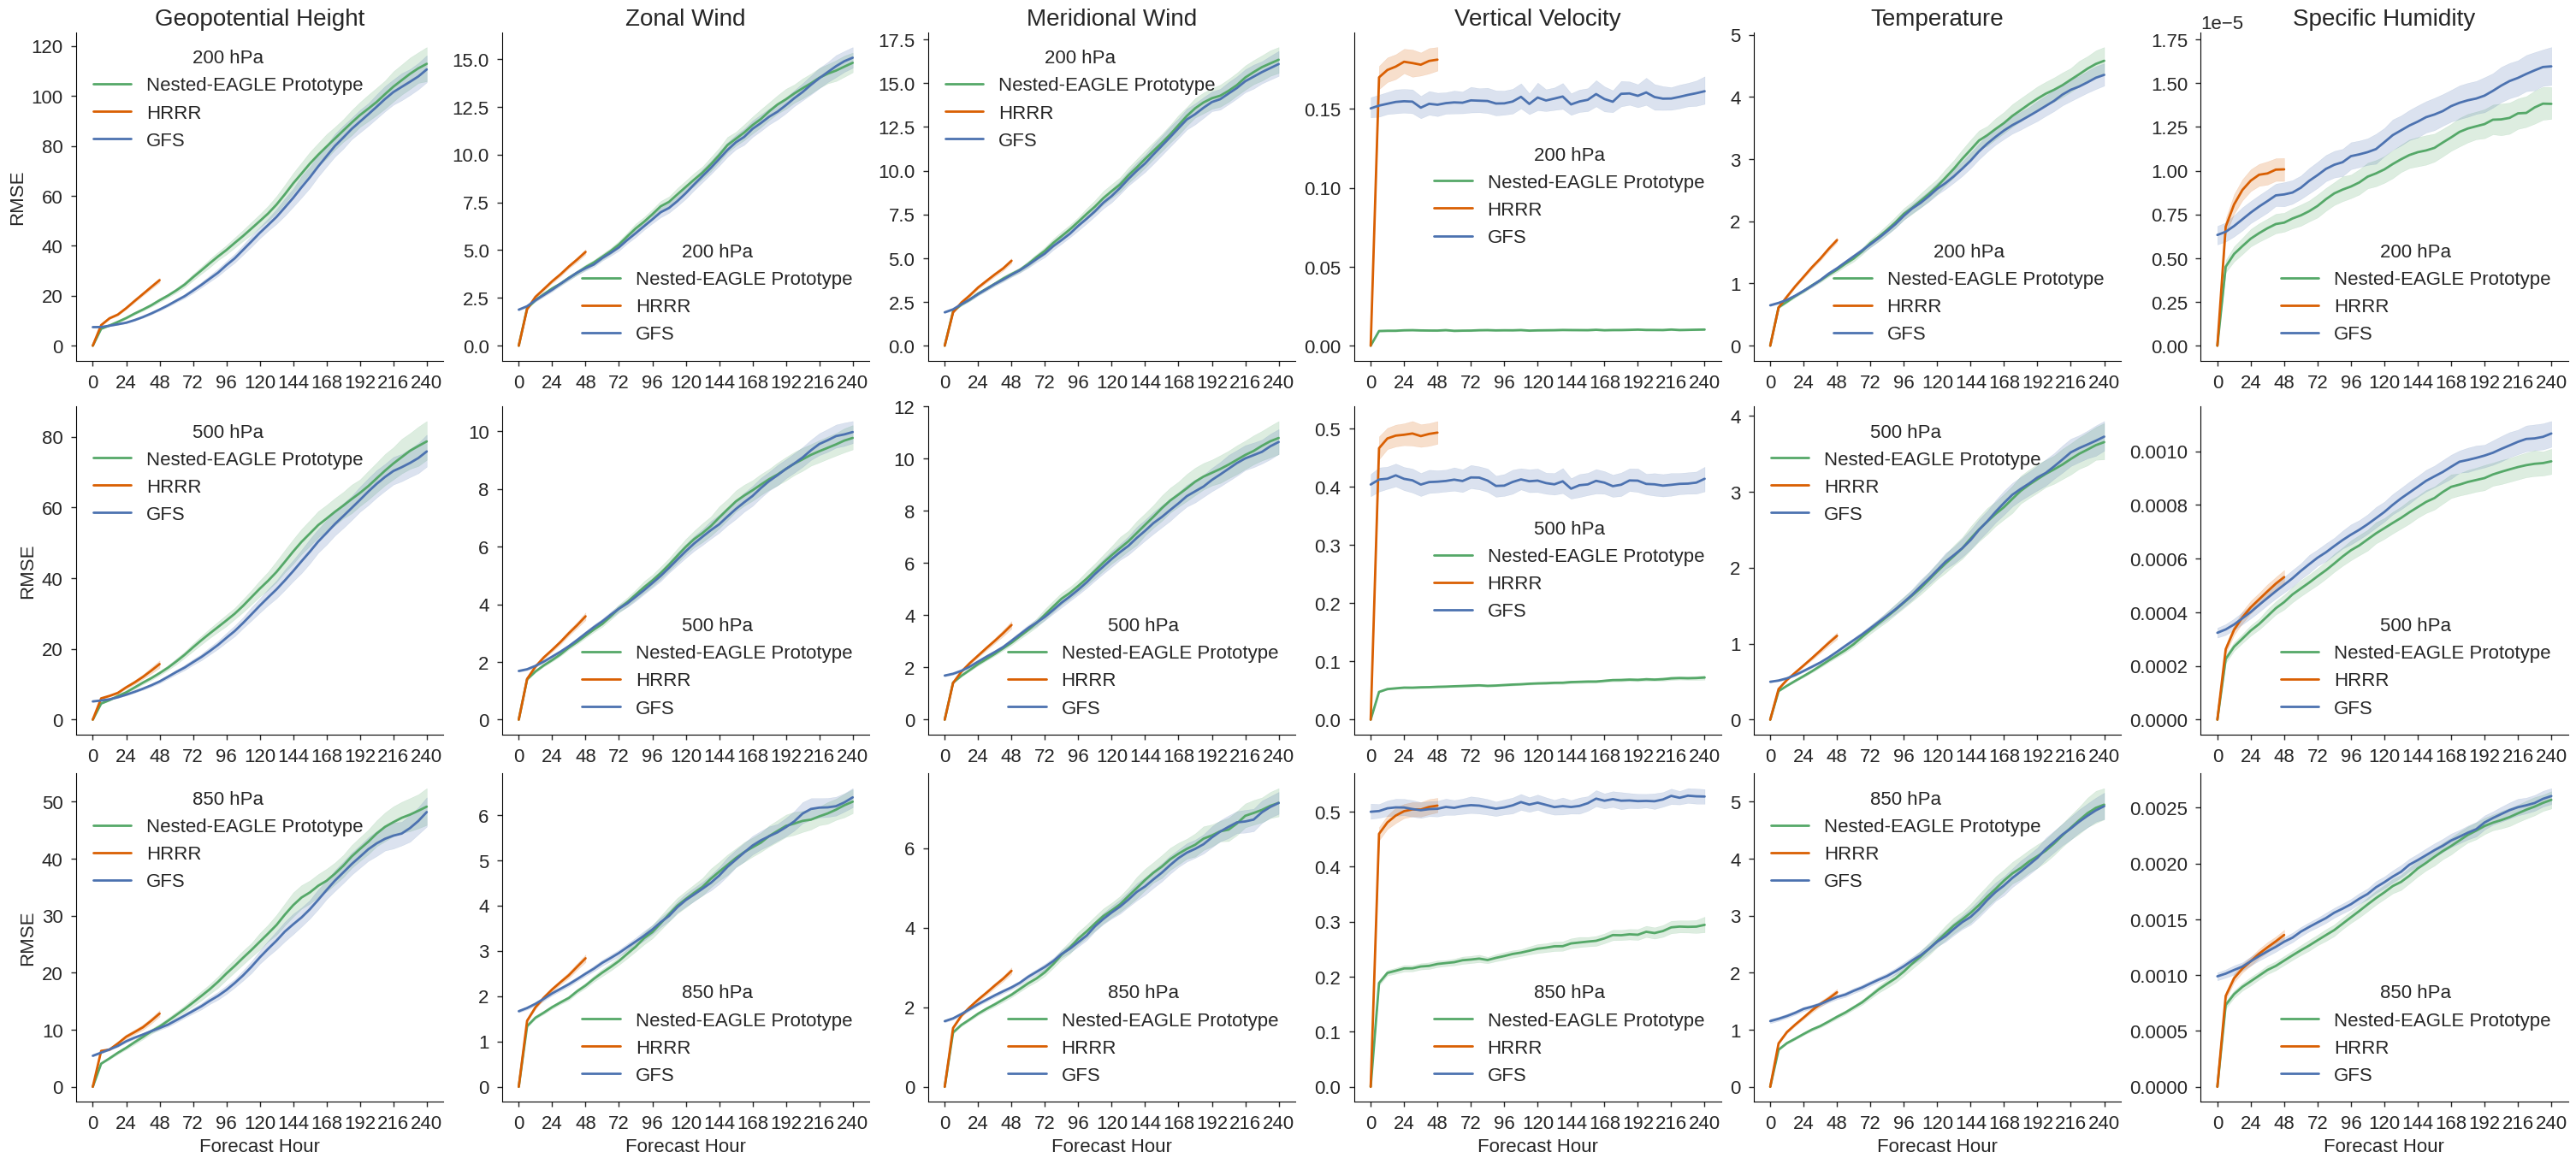

In [13]:
fig, axs = plot_level_vars(["gh", "u", "v", "w", "t", "q"])
fig.savefig(f"figures/plevel_10d_rmse_6fields.jpeg", dpi=300, bbox_inches="tight")